# Polarization of source

Author: Luis Miguel Sanchez Brea

Date:   17/01/2018

Purpose: Ecograb project, polariscope callibration

We have diode laser at 850 nm (current = 250 mA)
We have lens for collimating and Thorlabs DG10-600-B diffuser

We have only polarizer 1 Thorlabs LPNIRE100-B

We rotate polarizer in order to see if light source is linearly polarized

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import hickle as hkl
import time
import pprint
from __future__ import print_function

### Motors definition

In [57]:
from polarimeter.motors.rotary_motors import Motors
Comports = [4, 3,   5, 7] 
Vels = [600, 600, 600, 600]

In [58]:
motors = Motors(RS232_COMPORT=Comports) 

Connected to (c)2013 Physik Instrumente(PI) Karlsruhe, C-663.11,0,1.2.1.0

Connected to (c)2013 Physik Instrumente(PI) Karlsruhe, C-663.11,0,1.2.1.0

Connected to (c)2013 Physik Instrumente(PI) Karlsruhe, C-663.11,0,1.2.1.0

Connected to (c)2013 Physik Instrumente(PI) Karlsruhe, C-663.11,0,1.2.1.0



### Labjack definition

In [59]:
import u3
import LabJackPython


V=1.
mV=V/1000


def to_bits(variable_integer, num_bits=16, verbose=True):
    """
    takes an integer an generates a list with bits

    Args:
        variable_integer (int): integer with data
        num_bits (int): num of output bits: 8,16, 32, 64
    """
    if num_bits == 8:
        output = map(int, [x for x in '{:08b}'.format(variable_integer)])
    elif num_bits == 16:
        output = map(int, [x for x in '{:016b}'.format(variable_integer)])
    elif num_bits == 32:
        output = map(int, [x for x in '{:032b}'.format(variable_integer)])
    elif num_bits == 64:
        output = map(int, [x for x in '{:064b}'.format(variable_integer)])

    if verbose is True:
        print( output)
    return output

In [60]:
# loads labjack
d=u3.U3()

In [61]:
print("\n Callibration data:")
data_callibration=d.getCalibrationData()
pprint.pprint(data_callibration)


 Callibration data:
{'dac0Offset': -0.6872114308644086,
 'dac0Slope': 50.9896679460071,
 'dac1Offset': -0.701979405945167,
 'dac1Slope': 50.91950369440019,
 'hvAIN0Offset': -10.518997645704076,
 'hvAIN0Slope': 0.00031980290077626705,
 'hvAIN1Offset': -10.489001986570656,
 'hvAIN1Slope': 0.0003192389849573374,
 'hvAIN2Offset': -10.523998295888305,
 'hvAIN2Slope': 0.0003195337485522032,
 'hvAIN3Offset': -10.51609767600894,
 'hvAIN3Slope': 0.00031975959427654743,
 'lvDiffOffset': -2.490987469209358,
 'lvDiffSlope': 7.56862573325634e-05,
 'lvSEOffset': 0.001728925621137023,
 'lvSESlope': 3.775535151362419e-05,
 'tempSlope': 0.01259785215370357,
 'vRef1.5AtCal': 0.0,
 'vRefAtCAl': 2.486867640633136,
 'vRegAtCal': 0.0}


In [62]:
AIN_number=1
ain1bits, = d.getFeedback(u3.AIN(AIN_number)) # Read from raw bits from AIN0
ainValue = d.binaryToCalibratedAnalogVoltage(ain1bits, isLowVoltage = False, channelNumber = 0)
print(ainValue)


0.686895997496


In [63]:
def get_intensity(AIN_number=1, verbose=True):
    ain1bits, = d.getFeedback(u3.AIN(AIN_number)) # Read from raw bits from AIN0
    ainValue = d.binaryToCalibratedAnalogVoltage(ain1bits, isLowVoltage = False, channelNumber = 0)
    if verbose is True:
        print("{:2.2f}".format(ainValue), end=', ')
    return ainValue

### Experiment

In [72]:
positions=sp.linspace(0,360,90)
intensities=sp.zeros_like(positions,dtype=float)

In [73]:
for i, position in enumerate(positions):
    motors.move(
        positions=[180, position, 180, 180], velocities=Vels, verbose=False)
    intensities[i]=get_intensity(verbose=True)


2.00, 1.79, 1.58, 1.38, 1.17, 0.98, 0.80, 0.64, 0.52, 0.40, 0.31, 0.25, 0.22, 0.21, 0.24, 0.29, 0.36, 0.47, 0.61, 0.76, 0.93, 1.11, 1.30, 1.51, 1.71, 1.90, 2.10, 2.28, 2.45, 2.62, 2.75, 2.87, 2.96, 3.02, 3.07, 3.08, 3.07, 3.02, 2.94, 2.85, 2.73, 2.59, 2.44, 2.26, 2.07, 1.87, 1.67, 1.47, 1.27, 1.08, 0.89, 0.73, 0.57, 0.46, 0.35, 0.28, 0.23, 0.22, 0.22, 0.26, 0.33, 0.43, 0.54, 0.68, 0.84, 1.02, 1.21, 1.41, 1.61, 1.83, 2.03, 2.23, 2.41, 2.58, 2.73, 2.87, 2.97, 3.06, 3.12, 3.14, 3.14, 3.12, 3.05, 2.96, 2.85, 2.71, 2.56, 2.39, 2.20, 1.99, 

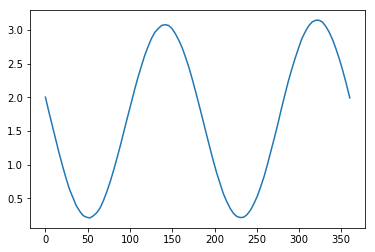

In [74]:
plt.figure()
plt.plot(positions, intensities)
plt.show()

## Fitting data to sine

Fit examples with sinusoidal functions

In [75]:

from scipy import optimize


In [76]:
# Fit the first set
fitfunc = lambda p, x: p[0]+p[1]*np.cos(2*np.pi/p[2]*(x-p[3])) # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function

In [77]:
p0 = [1.25,2.5, 180, 0.] # Initial guess for the parameters
p1, success = optimize.leastsq(errfunc, p0[:], args=(positions, intensities))

y_fitting=fitfunc(p1, positions)
residuals=intensities-y_fitting


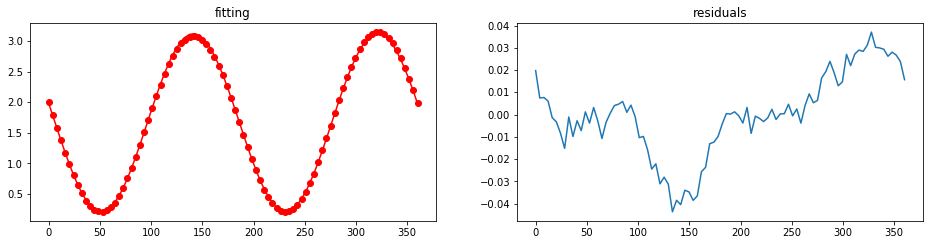

In [78]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.plot(positions, intensities, "ro")
plt.plot(positions,y_fitting , "r-") # Plot of the data and the fit
plt.title('fitting')

plt.subplot(2,2,2)
plt.plot(positions, residuals)
plt.title('residuals')
plt.show()

In [79]:
print(p1)

[   1.66516728    1.45180469  179.93799287  -38.68098583]


## Analysis of results

In [81]:
angle_max=p1[3]+180
min_light=p1[0]-p1[1]
max_light=p1[0]+p1[1]

print("angle = {} º, min_intensity = {} V, max_intensity ={}".format(angle_max, min_light, max_light))
print("intensities: min = {}, max = {}".format(intensities.min(), intensities.max()))

angle = 141.319014166 º, min_intensity = 0.213362589266 V, max_intensity =3.11697197917
intensities: min = 0.211029281141, max = 3.14298227546


## Go to Maximum intensity position

In [83]:
motors.move(
        positions=[180, angle_max, 180, 180], velocities=Vels, verbose=False)
motors.get_position()
get_intensity(verbose=True)

current positions = ([ 180.], [ 141.319], [ 180.], [ 180.])
0.02, 

0.02170596388168633

## Final: Close

In [84]:
motors.close()
del motors
LabJackPython.Close()